In [2]:
import numpy as np
import numpy.typing as npt
import matplotlib.pyplot as plt

classical_electron_radius = 2.81794032e-15  # [m]
elec_rest_energy = 8.1871057880e-14  # [J]
MeV = 1.6022e-13  # [J]
barn = 1e-28  # [m2]
mol = 6.021e23  # [/mol]
material_number_density = 19320000 / 196.97 * mol * 79
alpha = 1/137
speed_of_light = 299792458
Z = 79
hbar = 1.054571817e-34


/usr/local/lib/python3.10/dist-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [6]:
def d_(x: npt.NDArray) -> npt.NDArray:
    return x[1] - x[0]


def dsolid_dangle(a: npt.NDArray) -> npt.NDArray:
    return 2 * np.pi * np.sin(a)


def gamma_cross_section_density_total(energy_in: npt.NDArray) -> npt.NDArray:
    s0 = 6.651e-29  # [m2]
    a0 = energy_in / elec_rest_energy
    return s0 * 3 / 8 / a0 * (np.log(2 * a0) + 0.5) * material_number_density


# returns [/m /st]
def gamma_cross_section_density_compton(
    energy_in: npt.NDArray, phot_angle_out: npt.NDArray
) -> npt.NDArray:
    alpha_0 = energy_in / elec_rest_energy
    cos_theta = np.cos(phot_angle_out)
    return (
        classical_electron_radius**2
        * (1 + cos_theta**2)
        / (1 + alpha_0 * (1 - cos_theta)) ** 2
        * (
            1
            + (alpha_0**2 * (1 - cos_theta) ** 2)
            / ((1 + cos_theta**2) * (1 + alpha_0 * (1 - cos_theta)))
        )
    ) * material_number_density


def compton_elec_params(
    phot_energy_in: npt.NDArray, phot_angle_out: npt.NDArray
) -> tuple[
    npt.NDArray,  # elec_energy_out
    npt.NDArray,  # elec_angle_out
]:
    a_0 = phot_energy_in / elec_rest_energy
    a = a_0 / (1 + a_0 * (1 - np.cos(phot_angle_out)))
    elec_energy_out = (a_0 - a) * elec_rest_energy
    elec_angle_out = np.arctan(1 / ((a_0 + 1)*np.tan(phot_angle_out/2))) #* np.sqrt((2 * a_0 * a) / (a_0 - a) - 1)
    return elec_energy_out, elec_angle_out

In [4]:
gamma_cross_section_density_total(np.array([5*MeV]))/material_number_density/barn*79

array([6.99547516])

/tmp/ipykernel_860467/1201468867.py:42: RuntimeWarning: divide by zero encountered in divide
  elec_angle_out = np.arctan(1 / ((a_0 + 1)*np.tan(phot_angle_out/2))) #* np.sqrt((2 * a_0 * a) / (a_0 - a) - 1)


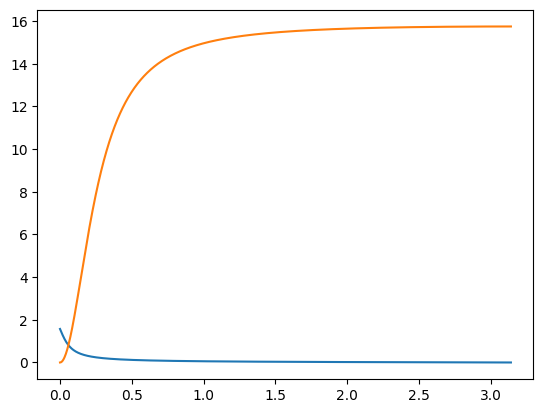

In [7]:
X =np.linspace(0,np.pi,1000)
plt.plot(X, compton_elec_params(16*MeV, X)[1])
plt.plot(X, compton_elec_params(16*MeV, X)[0]/MeV)

/tmp/ipykernel_796159/1133858662.py:17: RuntimeWarning: divide by zero encountered in divide
  elec_angle_out = np.arctan(1 / (a_0 + 1)) * np.sqrt((2 * a_0 * a) / (a_0 - a) - 1)
/tmp/ipykernel_796159/1133858662.py:20: RuntimeWarning: invalid value encountered in tan
  value_0 = np.pow((a_0 + 1) * np.tan(psi), 2)
/tmp/ipykernel_796159/1133858662.py:26: RuntimeWarning: invalid value encountered in cos
  * (1 / (np.cos(psi) ** 3))


(np.float64(7397.628276829559), np.float64(17.233151470447826))

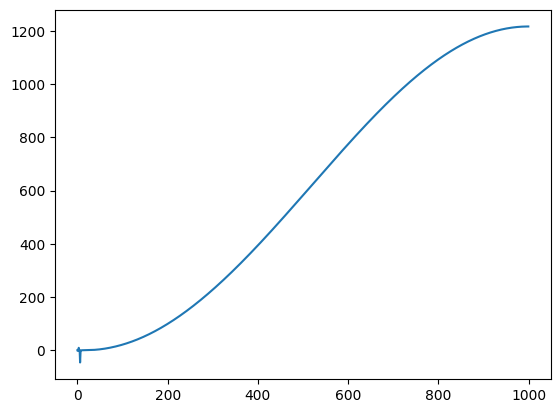

In [35]:


def gcsdt(energy_in: npt.NDArray) -> npt.NDArray:
    M = elec_rest_energy / energy_in
    s0 = 6.651e-25 * 1e-4 # [m2]
    a0 = 1/M
    csd_compton_total = s0 *3/8 *M *(np.log(2*a0)+0.5) * material_number_density

    return csd_compton_total

# returns [/m /st]
def gcsd(
    energy_in: npt.NDArray, phot_angle_out: npt.NDArray
) -> npt.NDArray:
    # # return np.zeros_like(energy_in) + 0.001 * (1 + np.cos(phot_angle_out))/(np.pi*2)

    a_0 = energy_in / elec_rest_energy
    a = a_0 / (1 + a_0 * (1 - np.cos(phot_angle_out)))
    elec_angle_out = np.arctan(1 / (a_0 + 1)) * np.sqrt((2 * a_0 * a) / (a_0 - a) - 1)

    psi = elec_angle_out
    value_0 = np.pow((a_0 + 1) * np.tan(psi), 2)

    # [0609B], eqn 12
    return (
        (classical_electron_radius**2 / 2)
        * ((2 * (a_0 + 1)) / (value_0 + 2 * a_0 + 1)) ** 2
        * (1 / (np.cos(psi) ** 3))
        * (
            1
            + ((value_0 - 1) / (value_0 + 1)) ** 2
            + (4 * a_0**2) / ((value_0 + 1) * (value_0 + 2 * a_0 + 1))
        )
    ) * material_number_density


X =np.linspace(0,np.pi,1000)
Y = gcsd(16*MeV, X)
Y[np.isnan(Y)] = 0

plt.plot(Y)

np.sum(Y*(X[1]-X[0])*np.sin(X)*2*np.pi), gcsdt(16*MeV)